# House Prices Dataset (https://www.kaggle.com/datasets/harlfoxem/housesalesprediction)

## Imports + Getting Data

In [1]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression as sklearn_linreg
from diffprivlib.models import LinearRegression as dp_linreg
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv("../../Data/kc_house_data.csv")
df.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,6414100192,20141209T000000,538000.0,3,2.25,2570,7242,2.0,0,0,...,7,2170,400,1951,1991,98125,47.7210,-122.319,1690,7639
2,5631500400,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
3,2487200875,20141209T000000,604000.0,4,3.00,1960,5000,1.0,0,0,...,7,1050,910,1965,0,98136,47.5208,-122.393,1360,5000
4,1954400510,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503


## Pre-Processing

In [4]:
df["yrs_since_reno"] = df.apply(lambda r: 2015 - max(r["yr_renovated"], r["yr_built"]), axis=1)
df = df.drop(["id", "date", "lat", "long", "yr_renovated"], axis=1)
df.head()

,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,zipcode,sqft_living15,sqft_lot15,yrs_since_reno
0,221900.0,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,98178,1340,5650,60
1,538000.0,3,2.25,2570,7242,2.0,0,0,3,7,2170,400,1951,98125,1690,7639,24
2,180000.0,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,98028,2720,8062,82
3,604000.0,4,3.00,1960,5000,1.0,0,0,5,7,1050,910,1965,98136,1360,5000,50
4,510000.0,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,98074,1800,7503,28


In [5]:
categorical_cols = ["bedrooms", "bathrooms", "floors", "waterfront", "view", "condition", "grade", "zipcode"]
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)

In [6]:
X = df.drop("price", axis=1)
y = df[["price"]]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)

In [7]:
scaler = preprocessing.StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## Helper Functions

In [4]:
# Get Simulated Property Tax Surplus:
#   - Property tax is simulated as 1% of predicted house value
def getPropertyTaxSurplus(y, y_pred):
    y = y["price"].tolist()
    y_pred = y_pred.flatten()
    return np.sum([(y[i] - y_pred[i]) * 0.01 for i in range(len(y))])

getPropertyTaxSurplusScorer = make_scorer(getPropertyTaxSurplus)

# Get K Features with Highest Absolute Coefficients from Baseline Linear Regression
def getKBestFeatures(X_train_scaled, X_test_scaled, baseline_coefs, k):
    abs_baseline_coefs = np.absolute(baseline_coefs)
    ind = np.argpartition(abs_baseline_coefs, -k)[-k:]
    return pd.DataFrame(X_train_scaled).iloc[:, ind], pd.DataFrame(X_test_scaled).iloc[:, ind]

## Baseline Model

In [12]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_scaled.shape[1])]
max_bounds_X = [3 for _ in range(X_train_scaled.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Baseline Linear Regression
# Create "baseline" Linear Regression model using DP version with infinite epsilon
lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0, 1e7)).fit(X_train_scaled, y_train)  
lr_scores = cross_validate(lr, X_test_scaled, y_test, cv=5, scoring=scoring)

# Get RMSE
lr_err = np.mean(np.power(np.abs(lr_scores["test_MSE"]), 0.5))

# Get Property Tax Surplus
lr_tax_surplus = np.mean(lr_scores["test_property_tax_surplus"])

print("Regular RMSE:", lr_err)
print("Regular Tax Surplus:", lr_tax_surplus)

Regular RMSE: 1269145.8370447468
Regular Tax Surplus: -5812424.666578703


## Comparing SKLearn Baseline Model vs DP Baseline Model

In [13]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

ks = range(1, len(X_train.columns) + 1)

sklearn_base_lr_tax_surpluses = []
sklearn_base_lr_errs = []
dp_base_lr_tax_surpluses = []
dp_base_lr_errs = []
base_coef_diffs = []


for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    # Define bounds for each of the features
    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    # Create baseline Linear Regression models using SKLearn and DP
    sklearn_base_lr = sklearn_linreg().fit(X_train_topk, y_train)
    dp_base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_topk, y_train)  
    
    sklearn_base_lr_scores = cross_validate(sklearn_base_lr, X_test_topk, y_test, cv=5, scoring=scoring)
    dp_base_lr_scores = cross_validate(dp_base_lr, X_test_topk, y_test, cv=5, scoring=scoring)

    # Get RMSE
    sklearn_base_lr_err = np.mean(np.power(np.abs(sklearn_base_lr_scores["test_MSE"]), 0.5))
    sklearn_base_lr_errs.append(sklearn_base_lr_err)
    dp_base_lr_err = np.mean(np.power(np.abs(dp_base_lr_scores["test_MSE"]), 0.5))
    dp_base_lr_errs.append(dp_base_lr_err)

    # Get Coefficient Differences
    base_coef_diffs.append(np.linalg.norm(sklearn_base_lr.coef_ - dp_base_lr.coef_))

    # Get student fail prediction accuracy
    sklearn_base_lr_tax_surplus = np.mean(sklearn_base_lr_scores["test_property_tax_surplus"])
    sklearn_base_lr_tax_surpluses.append(sklearn_base_lr_tax_surplus)
    dp_base_lr_tax_surplus = np.mean(dp_base_lr_scores["test_property_tax_surplus"])
    dp_base_lr_tax_surpluses.append(dp_base_lr_tax_surplus)

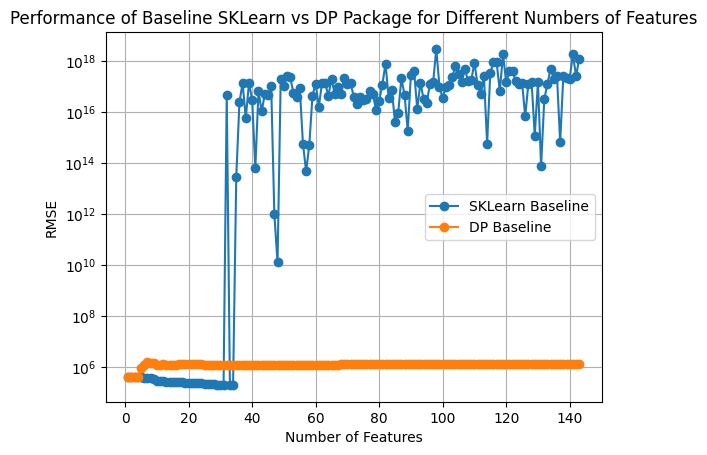

In [14]:
plt.plot(ks, sklearn_base_lr_errs, '-o', label="SKLearn Baseline")
plt.plot(ks, dp_base_lr_errs, '-o', label="DP Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Performance of Baseline SKLearn vs DP Package for Different Numbers of Features")
plt.grid(axis="both")
plt.legend();

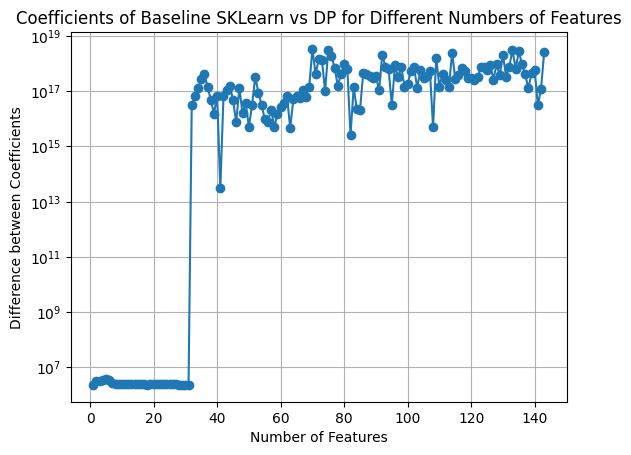

In [15]:
plt.plot(ks, base_coef_diffs, '-o')
plt.xlabel("Number of Features")
plt.ylabel("Difference between Coefficients")
plt.yscale("log")
plt.title("Coefficients of Baseline SKLearn vs DP for Different Numbers of Features")
plt.grid(axis="both");

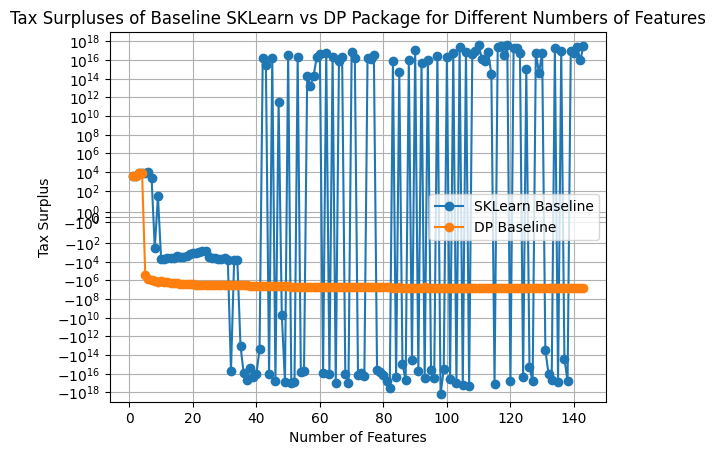

In [16]:
plt.plot(ks, sklearn_base_lr_tax_surpluses, '-o', label="SKLearn Baseline")
plt.plot(ks, dp_base_lr_tax_surpluses, '-o', label="DP Baseline")
plt.yscale("symlog")
plt.ylim(-10e18, 10e18)
plt.xlabel("Number of Features")
plt.ylabel("Tax Surplus")
plt.title("Tax Surpluses of Baseline SKLearn vs DP Package for Different Numbers of Features")
plt.grid(axis="both")
plt.legend();

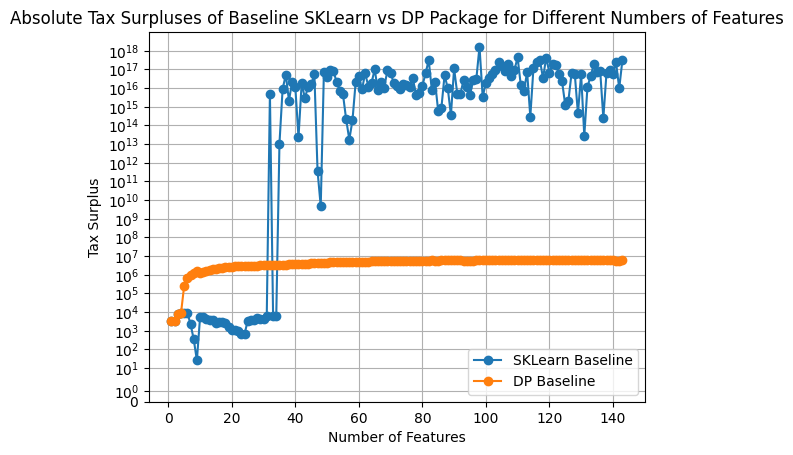

In [20]:
plt.plot(ks, np.abs(sklearn_base_lr_tax_surpluses), '-o', label="SKLearn Baseline")
plt.plot(ks, np.abs(dp_base_lr_tax_surpluses), '-o', label="DP Baseline")
plt.yscale("symlog")
plt.ylim(0, 10e18)
plt.xlabel("Number of Features")
plt.ylabel("Tax Surplus")
plt.title("Absolute Tax Surpluses of Baseline SKLearn vs DP Package for Different Numbers of Features")
plt.grid(axis="both")
plt.legend();

## Trying for Different Numbers of Features

In [186]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

ks = range(1, len(X_train.columns) + 1)
epsilons = [1, 5, 10]

base_lr_tax_surpluses = []
base_lr_errs = []

priv_lr_errors = [[] for _ in epsilons]
priv_lr_tax_surpluses = [[] for _ in epsilons]
lr_coef_distances = [[] for _ in epsilons]

for k in range(len(ks)):
    X_train_topk, X_test_topk = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, ks[k])

    # Define bounds for each of the features
    min_bounds_X = [-3 for _ in range(k + 1)]
    max_bounds_X = [3 for _ in range(k + 1)]
    bounds_X = (min_bounds_X, max_bounds_X)

    # Create "baseline" Linear Regression model using DP version with infinite epsilon
    base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_topk, y_train)  
    base_lr_scores = cross_validate(base_lr, X_test_topk, y_test, cv=5, scoring=scoring)

    # Get tax surplus
    base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])
    base_lr_tax_surpluses.append(base_lr_tax_surplus)
    
    # Get RMSE
    base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))
    base_lr_errs.append(base_lr_err)

    for e in range(len(epsilons)):
        priv_lr = dp_linreg(epsilon=epsilons[e], bounds_X=bounds_X, bounds_y=(0,1e7), random_state=42). fit(X_train_topk, y_train)
        priv_lr_scores = cross_validate(priv_lr, X_test_topk, y_test, cv=5, scoring=scoring)
        
        # Get tax surpluses
        priv_lr_tax_surpluses[e].append(np.mean(priv_lr_scores['test_property_tax_surplus']))

        # Get RMSE
        priv_lr_errors[e].append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))
        # priv_lr_errors[e].append(np.mean(np.power(np.abs(priv_lr_scores), 0.5)))

        # Get Coefficient Distances
        lr_coef_distances[e].append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))

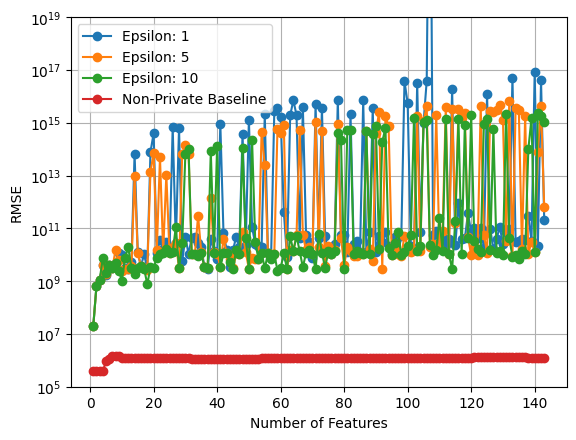

In [187]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_errors[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_errs * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.ylim(10e4, 10e18)
plt.title("Performance of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

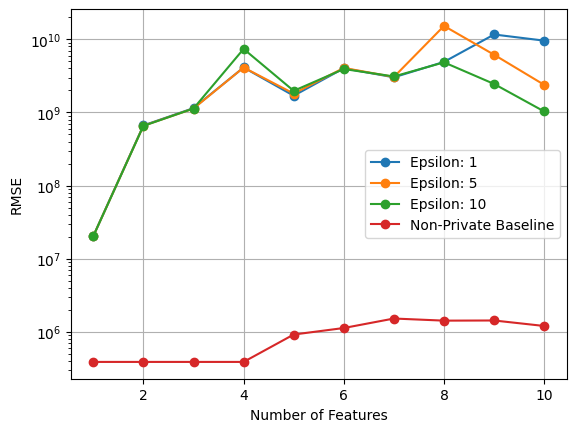

In [188]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], priv_lr_errors[e][:10], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], base_lr_errs[:10] * np.ones(10), '-o', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

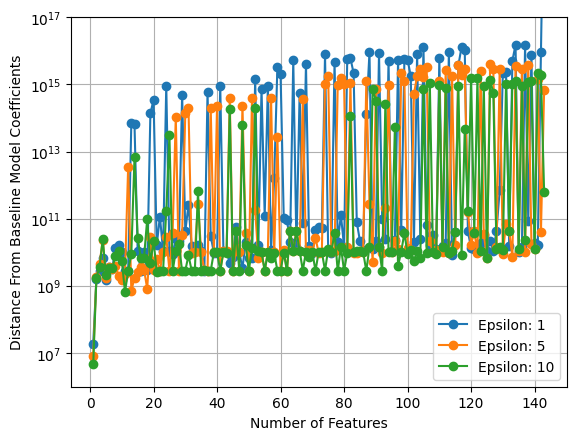

In [189]:
for e in range(len(epsilons)):
    plt.plot(ks, lr_coef_distances[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.yscale("log")
plt.ylim(10e5, 10e16)
plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

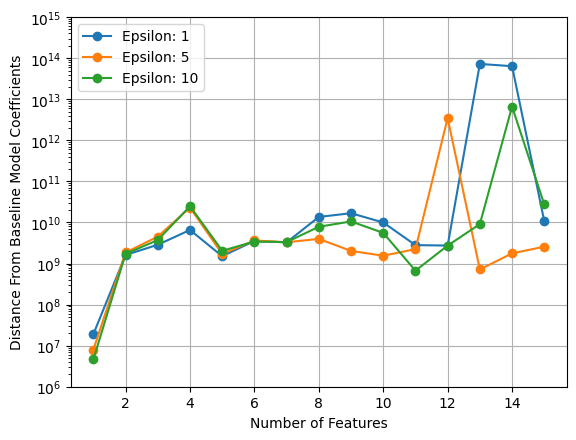

In [190]:
for e in range(len(epsilons)):
    plt.plot(ks[:15], lr_coef_distances[e][:15], '-o', label=f"Epsilon: {epsilons[e]}")

plt.yscale("log")
plt.ylim(10e5, 10e14)
plt.xlabel("Number of Features")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.title("Coefficients of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

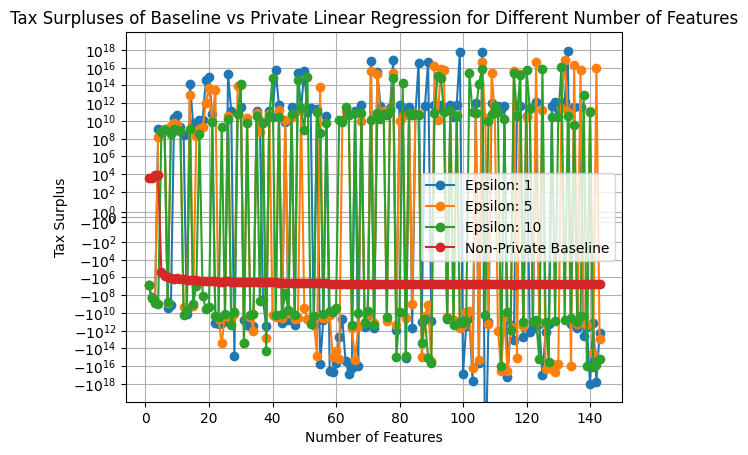

In [191]:
for e in range(len(epsilons)):
    plt.plot(ks, priv_lr_tax_surpluses[e], '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, base_lr_tax_surpluses * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.yscale("symlog")
plt.ylim(-10e19, 10e19)
plt.xlabel("Number of Features")
plt.ylabel("Tax Surplus")
plt.title("Tax Surpluses of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

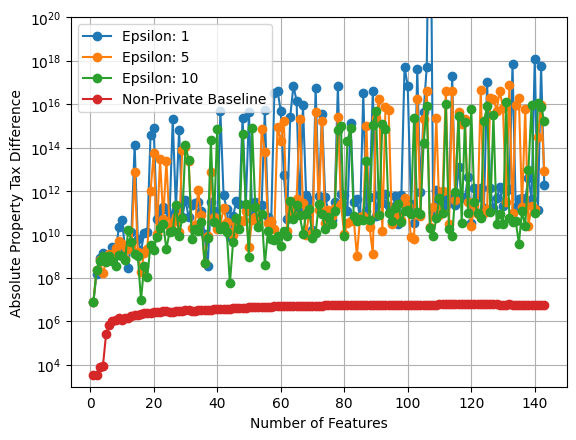

In [192]:
for e in range(len(epsilons)):
    plt.plot(ks, np.abs(priv_lr_tax_surpluses[e]), '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks, np.abs(base_lr_tax_surpluses) * np.ones_like(ks), '-o', label="Non-Private Baseline")
plt.yscale("log")
plt.ylim(10e2, 10e19)
plt.xlabel("Number of Features")
plt.ylabel("Absolute Property Tax Difference")
plt.title("Tax Surpluses of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

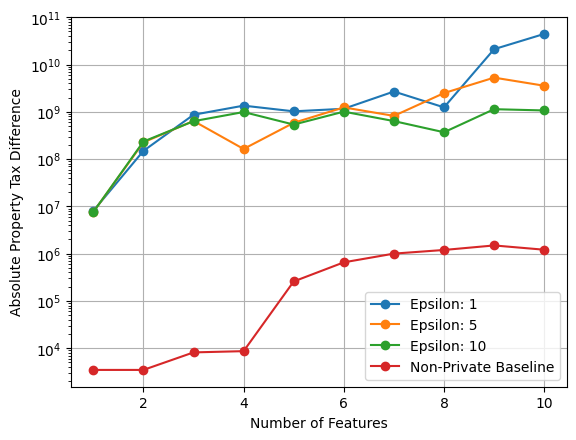

In [193]:
for e in range(len(epsilons)):
    plt.plot(ks[:10], np.abs(priv_lr_tax_surpluses[e][:10]), '-o', label=f"Epsilon: {epsilons[e]}")

plt.plot(ks[:10], np.abs(base_lr_tax_surpluses[:10]) * np.ones_like(ks[:10]), '-o', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("Number of Features")
plt.ylabel("Absolute Property Tax Difference")
plt.title("Tax Surpluses of Baseline vs Private Linear Regression for Different Number of Features")
plt.grid(axis="both")
plt.legend();

## Linear Regression

### Basic Linear Regression Comparison Using 1 Feature

In [194]:
X_train_top1, X_test_top1 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 1)

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top1.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top1.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_top1, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top1, y_test, cv=5, scoring=scoring)

# Get property tax surplus
base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])

# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Property Tax Surplus", base_lr_tax_surplus)

Baseline RMSE: 386649.5834113279
Baseline Property Tax Surplus 3479.276524346386


In [195]:
epsilons = np.logspace(-2, 3, 300)
priv_lr_errors = []
priv_lr_tax_surpluses = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer    
}

# Define bounds for each of the features.
min_bounds_X = [-3 for _ in range(X_train_top1.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top1.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

for e in epsilons:
    priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,1e7), random_state=42). fit(X_train_top1, y_train)
    priv_lr_scores = cross_validate(priv_lr, X_test_top1, y_test, cv=5, scoring=scoring)

    # Get property tax surplus
    priv_lr_tax_surpluses.append(np.mean(priv_lr_scores['test_property_tax_surplus']))

    # Get RMSE
    priv_lr_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

    # Get Coefficient Distances
    lr_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Property Tax Surpluses:", priv_lr_tax_surpluses)

Errors: [24747325.888653472, 24570572.105485633, 24400360.03673773, 24236461.04940576, 24078653.394078255, 23926722.136710588, 23780459.07300026, 23639662.62810978, 23504137.744169965, 23373695.757707514, 23248154.268888023, 23127337.00423663, 23011073.67428917, 22899199.827450197, 22791556.701168403, 22687991.07139092, 22588355.101138156, 22492506.188912146, 22400306.81756198, 22311624.40412938, 22226331.15111988, 22144303.899573755, 22065423.98424422, 21989577.09113613, 21916653.1176064, 21846546.03518159, 21779153.75521101, 21714377.997435935, 21652124.161523066, 21592301.20158627, 21534821.503691256, 21479600.7663185, 21426557.883739024, 21375614.83224112, 21326696.559129443, 21279730.874407806, 21234648.345041357, 21191382.19169035, 21149868.18779543, 21110044.560893033, 21071851.89603491, 21035233.041186474, 21000133.014480777, 20966498.913210176, 20934279.824447196, 20903426.737196524, 20873892.455998708, 20845631.5159228, 20818600.09891271, 20792755.951477364, 20768058.30374974

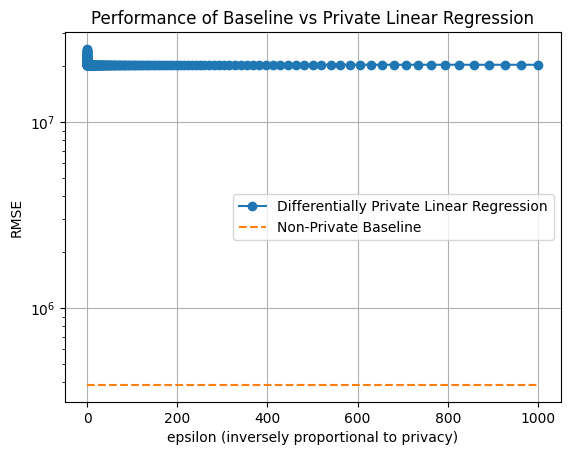

In [196]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

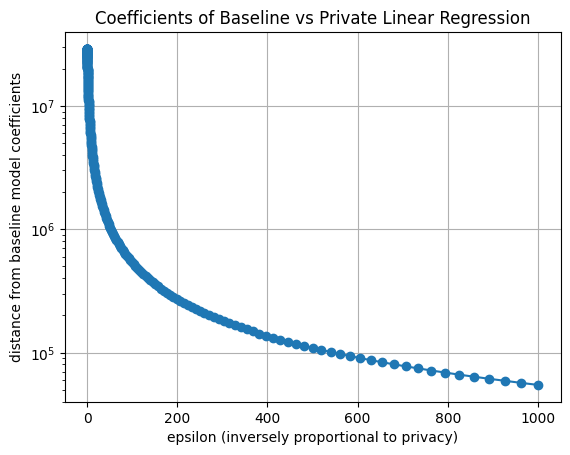

In [197]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("distance from baseline model coefficients")
plt.grid(axis="both")
plt.title("Coefficients of Baseline vs Private Linear Regression");

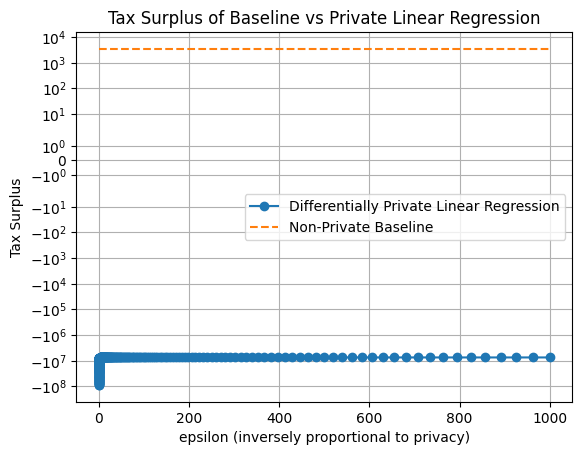

In [198]:
plt.plot(epsilons, priv_lr_tax_surpluses, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_tax_surplus * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("symlog")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Tax Surplus")
plt.title("Tax Surplus of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

### 1 Feature, But Averaging Performance

In [276]:
X_train_top1, X_test_top1 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 1)

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top1.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top1.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_top1, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top1, y_test, cv=5, scoring=scoring)

# Get property tax surplus
base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])

# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Property Tax Surplus", base_lr_tax_surplus)

Baseline RMSE: 386649.5834113279
Baseline Property Tax Surplus 3479.276524346386


In [277]:
epsilons = np.logspace(-1, 1, 75)
priv_lr_errors = []
priv_lr_tax_surpluses = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

for e in epsilons:
    current_tax_surpluses = []
    current_errors = []
    current_coef_distances = []

    for i in range(10):
        priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,1e7)). fit(X_train_top1, y_train)
        priv_lr_scores = cross_validate(priv_lr, X_test_top1, y_test, cv=5, scoring=scoring)

        # Get property tax surplus
        current_tax_surpluses.append(np.mean(priv_lr_scores['test_property_tax_surplus']))

        # Get RMSE
        current_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

        # Get Coefficient Distances
        current_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
    # Get average metrics across all 10 iterations
    priv_lr_errors.append(np.mean(current_errors))
    priv_lr_tax_surpluses.append(np.mean(current_tax_surpluses))
    lr_coef_distances.append(np.mean(current_coef_distances))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Tax Surpluses:", priv_lr_tax_surpluses)

Errors: [15485567.90661257, 10916373.69741917, 12787890.185936356, 18080599.51297752, 9120372.211807182, 31746590.887188006, 41358757.07234348, 2232018891.01271, 6112147.978311552, 4424653.220271981, 69491510.3003169, 10567922.866125584, 6522301.417780641, 11457125.816866567, 66612431.6869154, 18965988.142514724, 29530672.620224822, 11311851.714571012, 12137659.095518945, 16718744.605420459, 21113080.582751833, 12770090.152133867, 22428658.337465078, 15712741.966066042, 14733757.890271699, 9666706.669910034, 16993149.859279037, 19970326.977725018, 7600961.221910717, 6212197.157119685, 17501030.968925036, 4739757.206903076, 7695295.272474373, 8496336.87166973, 13248884.72809246, 40780143.48861675, 108680347.0934484, 159193414.50771973, 12713881.139304075, 32764932.142141126, 17328522.54339554, 8018916.635528604, 113505033.2728385, 14175554.642162373, 3268697.316633807, 7650434.90063403, 8240659.149071805, 7247450.293072537, 8035493.475587634, 3189001.2635811227, 18297959.45356682, 42127

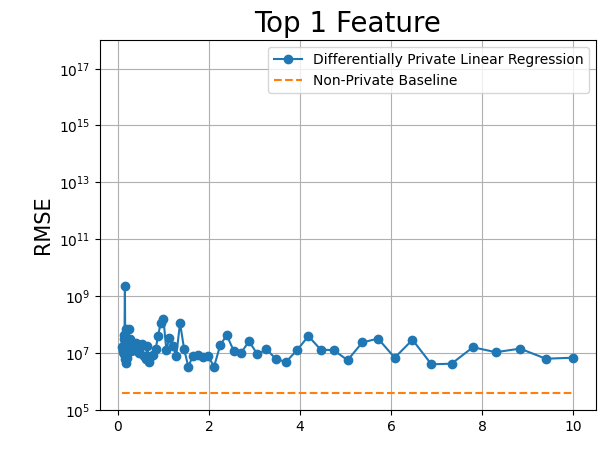

In [283]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.ylim(10e4, 10e17)
plt.legend();

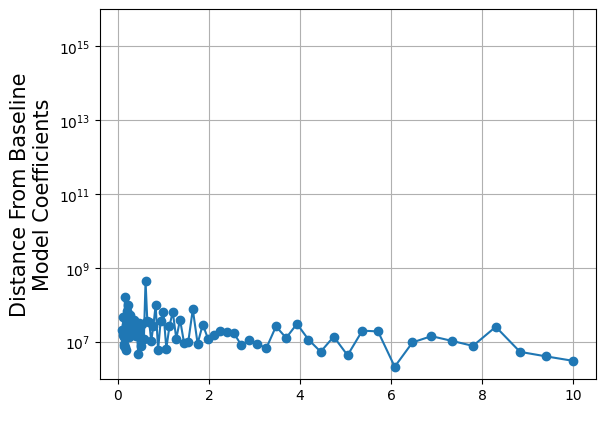

In [279]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline\nModel Coefficients")
plt.grid(axis="both")
plt.ylim(10e5, 10e15);
plt.title("Coefficients of DP vs Baseline Linear Regression");

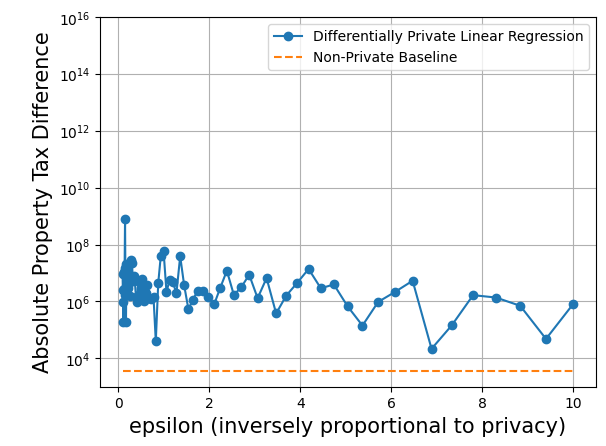

In [280]:
plt.plot(epsilons, np.abs(priv_lr_tax_surpluses), '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, np.abs(base_lr_tax_surplus) * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Absolute Property Tax Difference")
plt.title("Property Tax Difference of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.ylim(10e2, 10e15)
plt.legend();

### Linear Regression Comparison Using 3 Features

In [106]:
X_train_top3, X_test_top3 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 3)

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top3.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top3.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_top3, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top3, y_test, cv=5, scoring=scoring)

# Get property tax surplus
base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])

# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Property Tax Surplus", base_lr_tax_surplus)

Baseline RMSE: 386647.3608356685
Baseline Property Tax Surplus 8166.34943861292


In [107]:
epsilons = np.logspace(-2, 2, 300)
priv_lr_errors = []
priv_lr_tax_surpluses = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer    
}

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top3.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top3.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

for e in epsilons:
    priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,1e7), random_state=42). fit(X_train_top3, y_train)
    priv_lr_scores = cross_validate(priv_lr, X_test_top3, y_test, cv=5, scoring=scoring)

    # Get property tax surplus
    priv_lr_tax_surpluses.append(np.mean(priv_lr_scores['test_property_tax_surplus']))

    # Get RMSE
    priv_lr_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

    # Get Coefficient Distances
    lr_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Property Tax Surpluses:", priv_lr_tax_surpluses)

Errors: [1518944485.4814517, 1497246546.999077, 1476322356.2589254, 1456149328.1011405, 1436710975.621862, 1417996986.0003812, 1400003884.3644671, 1382736409.4167237, 1366209882.8542545, 1350454106.7440534, 1335519786.4608064, 1321489387.114966, 1308496257.0646462, 1296760242.979161, 1286658990.580056, 1278884807.7826004, 1274836591.919971, 1277794260.1431224, 1297606796.048759, 1383353208.5766518, 2.2657812945177375e+21, 45890173811.38312, 42310297121.763626, 38840613935.81227, 10488777827.859701, 10187195724.067833, 9895661116.471958, 9613810722.83133, 9341295193.924911, 9077778614.879284, 8822938020.075535, 8576462919.67293, 8338054837.801359, 8107426863.259329, 7884303211.367534, 7668418797.447904, 7459518822.951602, 7257358372.6030655, 1792268354.251411, 1770276173.302602, 1749053338.2317429, 1728570788.3176086, 1708800635.3061383, 1689716116.423794, 1671291548.6957479, 1653502285.0931492, 1636324671.5692186, 1619736006.5153115, 1603714501.0175948, 1588239240.5742078, 1573290148.9

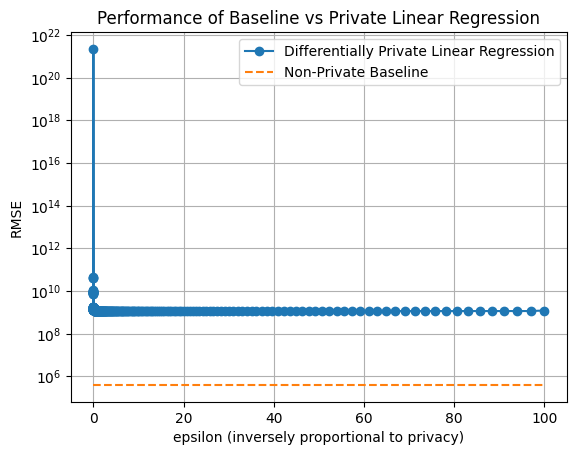

In [108]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

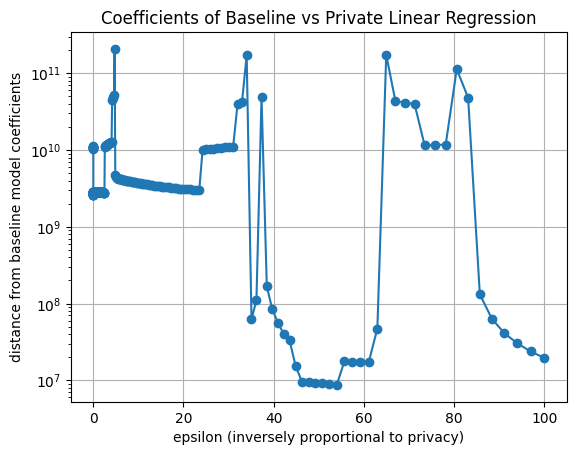

In [109]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("distance from baseline model coefficients")
plt.grid(axis="both")
plt.title("Coefficients of Baseline vs Private Linear Regression");

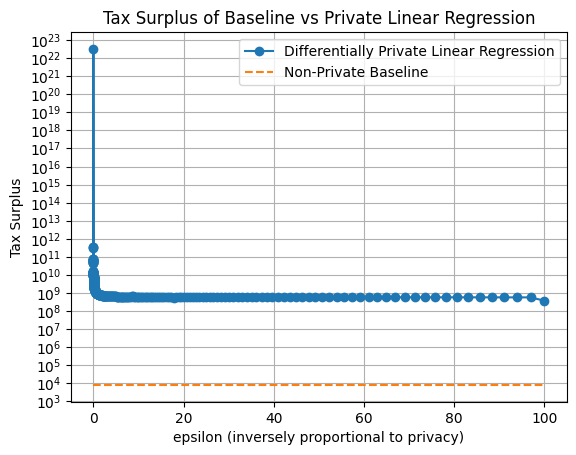

In [110]:
plt.plot(epsilons, np.abs(priv_lr_tax_surpluses), '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, np.abs(base_lr_tax_surplus) * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("symlog")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Tax Surplus")
plt.title("Tax Surplus of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

### 3 Features, But Averaging Performance

In [284]:
X_train_top3, X_test_top3 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 3)

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top3.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top3.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_top3, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top3, y_test, cv=5, scoring=scoring)

# Get property tax surplus
base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])

# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Property Tax Surplus", base_lr_tax_surplus)

Baseline RMSE: 386647.3608356685
Baseline Property Tax Surplus 8166.34943861292


In [289]:
epsilons = np.logspace(-1, 1, 75)
priv_lr_errors = []
priv_lr_tax_surpluses = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

for e in epsilons:
    current_tax_surpluses = []
    current_errors = []
    current_coef_distances = []

    for i in range(10):
        priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,1e7)). fit(X_train_top3, y_train)
        priv_lr_scores = cross_validate(priv_lr, X_test_top3, y_test, cv=5, scoring=scoring)

        # Get property tax surplus
        current_tax_surpluses.append(np.mean(priv_lr_scores['test_property_tax_surplus']))

        # Get RMSE
        current_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

        # Get Coefficient Distances
        current_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
    # Get average metrics across all 10 iterations
    priv_lr_errors.append(np.mean(current_errors))
    priv_lr_tax_surpluses.append(np.mean(current_tax_surpluses))
    lr_coef_distances.append(np.mean(current_coef_distances))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Tax Surpluses:", priv_lr_tax_surpluses)

Errors: [3699325381485.306, 850072012620.2314, 108096550487.76633, 1606327427109.4182, 772842492613.7961, 458229189139.2585, 630296179202.6865, 63542958100.04646, 79954196059.88074, 8719698273.853155, 9067115139.31636, 4541288424.236382, 1331293808254.898, 170342093107.1408, 24605258913.97818, 2142560052246.0015, 51934172776.932175, 236969663767.40274, 196347431304.899, 171722700889.0075, 946240268363.7172, 5093141917.262091, 2957581193.6203713, 1013300165.3182154, 2486151691.3026533, 285616666165.64325, 12929731845.93029, 11400504081.630627, 230236411949.9204, 40839996672.50063, 23563994459.904095, 11292902099.829844, 4008299089.903408, 1502479967.4709249, 1578258207.108013, 4021482562.363183, 33806066958.30361, 2624547040.0793123, 3921301825.182042, 79579121849.70639, 85249944072.9649, 5999240359.322935, 2116413856.2467723, 3637981017.3261404, 2672655972.0956416, 22177144928.83743, 3533898168.018004, 1946608942.301735, 6826065534.350969, 11346291354.356564, 72139022490.06355, 5317497

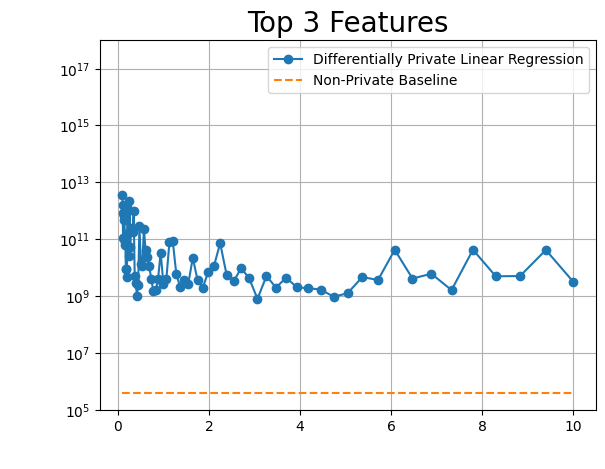

In [290]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.ylim(10e4, 10e17)
plt.legend();

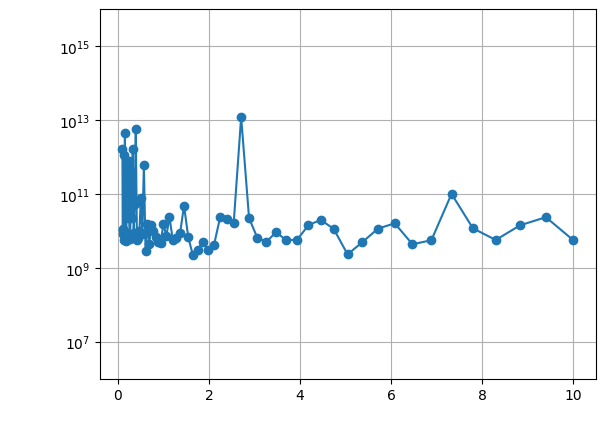

In [291]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.ylim(10e5, 10e15)
plt.grid(axis="both")
plt.title("Coefficients of DP vs Baseline Linear Regression");

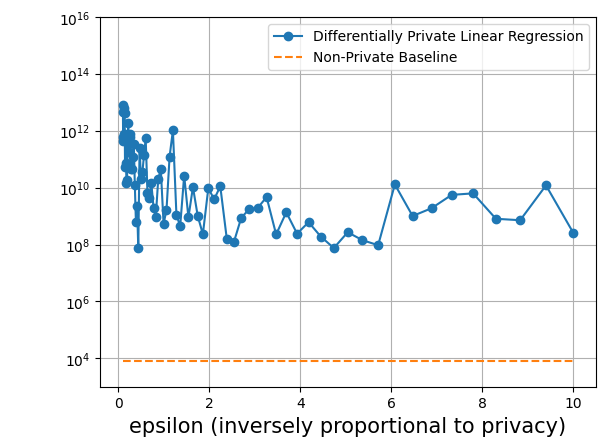

In [292]:
plt.plot(epsilons, np.abs(priv_lr_tax_surpluses), '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, np.abs(base_lr_tax_surplus) * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Absolute Property Tax Difference")
plt.title("Property Tax Difference of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.ylim(10e2, 10e15)
plt.legend();

### Linear Regression Comparison Using 10 Features

In [259]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

X_train_top10, X_test_top10 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 10)

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top10.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top10.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_top10, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top10, y_test, cv=5, scoring=scoring)

# Get property tax surplus
base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])

# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Tax Surplus:", base_lr_tax_surplus)

Baseline RMSE: 1199420.1594066063
Baseline Tax Surplus: -1212402.2944729428


In [27]:
epsilons = np.logspace(-1, 3, 300)
priv_lr_errors = []
priv_lr_tax_surpluses = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

for e in epsilons:
    priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,1e7), random_state=42). fit(X_train_top10, y_train)
    priv_lr_scores = cross_validate(priv_lr, X_test_top10, y_test, cv=5, scoring=scoring)

    # Get property tax surplus
    priv_lr_tax_surpluses.append(np.mean(priv_lr_scores['test_property_tax_surplus']))

    # Get RMSE
    priv_lr_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

    # Get Coefficient Distances
    lr_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Tax Surpluses:", priv_lr_tax_surpluses)

Errors: [4748125267.297857, 4704528931.242511, 4663776407.619126, 4625706454.981073, 4574262096.548564, 4540765142.532692, 4551723377.088236, 4618876044.081281, 4754863593.098407, 4973340392.990404, 5305687161.156921, 5803357878.2082815, 2332244745.214024, 5645044952.128698, 9288856407.403984, 13222821068.5887, 17392417527.745796, 21730768154.59086, 12037590301.20839, 12336874686.70963, 12680303583.386318, 13042914181.381989, 13397240058.357046, 13732668077.483553, 14039901513.562387, 14311512423.961304, 14542220766.883163, 14728927027.149546, 14870552630.483591, 14967752787.030949, 15022563678.992487, 15038035117.893768, 15017885556.756283, 14966202138.280106, 14887196409.959051, 14785017363.123764, 14663617589.814213, 14528549787.919369, 14393301777.403637, 14250309351.819855, 14105835724.771128, 13973742559.841183, 13928901329.365154, 346166773896.8115, 92957528095.25797, 24626701231.516003, 23527221622.68291, 22525741284.66695, 21612463714.903492, 20778186199.446766, 20014371985.02

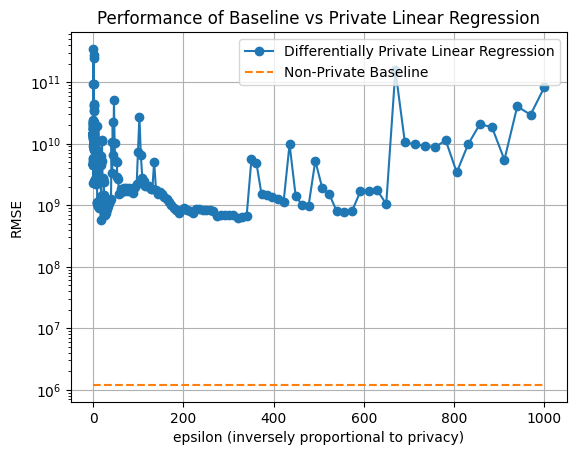

In [28]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

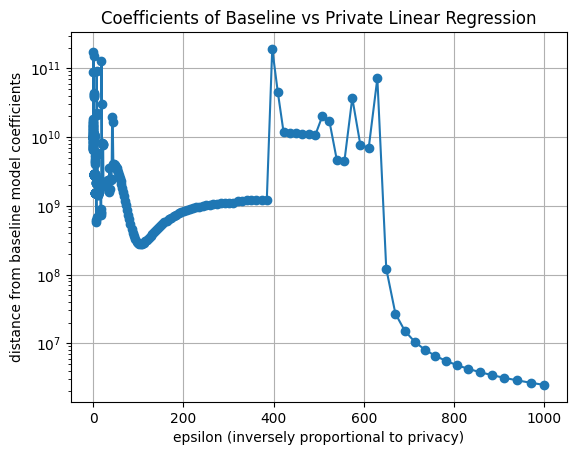

In [29]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("distance from baseline model coefficients")
plt.grid(axis="both")
plt.title("Coefficients of Baseline vs Private Linear Regression");

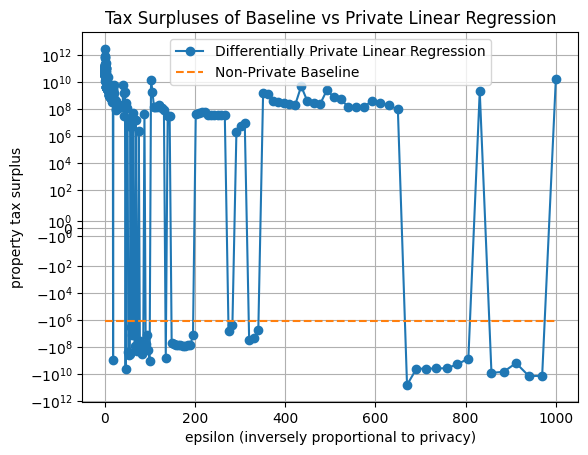

In [32]:
plt.plot(epsilons, priv_lr_tax_surpluses, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_tax_surplus * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("symlog")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("property tax surplus")
plt.title("Tax Surpluses of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

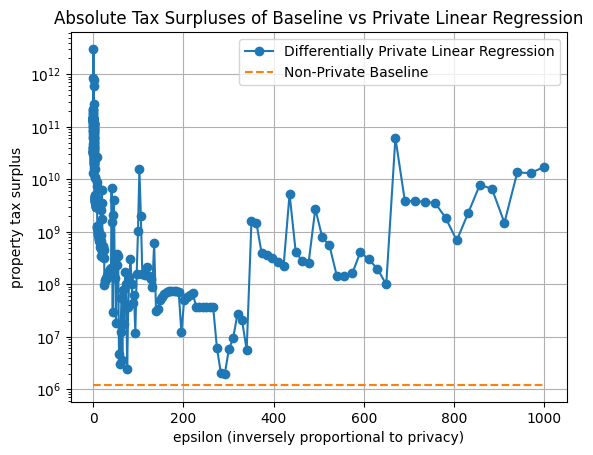

In [41]:
plt.plot(epsilons, np.abs(priv_lr_tax_surpluses), '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, np.abs(base_lr_tax_surplus) * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("property tax surplus")
plt.title("Absolute Tax Surpluses of Baseline vs Private Linear Regression")
plt.grid(axis="both")
plt.legend();

### 10 Features, But Averaging Performance

In [293]:
scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

X_train_top10, X_test_top10 = getKBestFeatures(X_train_scaled, X_test_scaled, lr.coef_, 10)

# Define bounds for each of the features
min_bounds_X = [-3 for _ in range(X_train_top10.shape[1])]
max_bounds_X = [3 for _ in range(X_train_top10.shape[1])]
bounds_X = (min_bounds_X, max_bounds_X)

# Create "baseline" Linear Regression model using DP version with infinite epsilon
base_lr = dp_linreg(epsilon=float('inf'), bounds_X=bounds_X, bounds_y=(0,1e7)).fit(X_train_top10, y_train)  
base_lr_scores = cross_validate(base_lr, X_test_top10, y_test, cv=5, scoring=scoring)

# Get property tax surplus
base_lr_tax_surplus = np.mean(base_lr_scores['test_property_tax_surplus'])

# Get RMSE
base_lr_err = np.mean(np.power(np.abs(base_lr_scores['test_MSE']), 0.5))

print("Baseline RMSE:", base_lr_err)
print("Baseline Tax Surplus:", base_lr_tax_surplus)

Baseline RMSE: 1199420.1594066063
Baseline Tax Surplus: -1212402.2944729428


In [294]:
epsilons = np.logspace(-1, 1, 75)
priv_lr_errors = []
priv_lr_tax_surpluses = []
lr_coef_distances = []

scoring = {
    'MSE': 'neg_mean_squared_error',
    'property_tax_surplus': getPropertyTaxSurplusScorer
}

for e in epsilons:
    current_tax_surpluses = []
    current_errors = []
    current_coef_distances = []

    for i in range(10):
        priv_lr = dp_linreg(epsilon=e, bounds_X=bounds_X, bounds_y=(0,1e7)). fit(X_train_top10, y_train)
        priv_lr_scores = cross_validate(priv_lr, X_test_top10, y_test, cv=5, scoring=scoring)

        # Get property tax surplus
        current_tax_surpluses.append(np.mean(priv_lr_scores['test_property_tax_surplus']))

        # Get RMSE
        current_errors.append(np.mean(np.power(np.abs(priv_lr_scores['test_MSE']), 0.5)))

        # Get Coefficient Distances
        current_coef_distances.append(np.linalg.norm(base_lr.coef_ - priv_lr.coef_))
    
    # Get average metrics across all 10 iterations
    priv_lr_errors.append(np.mean(current_errors))
    priv_lr_tax_surpluses.append(np.mean(current_tax_surpluses))
    lr_coef_distances.append(np.mean(current_coef_distances))
    
print("Errors:", priv_lr_errors)
print("Coefficient Distances:", lr_coef_distances)
print("Tax Surpluses:", priv_lr_tax_surpluses)

Errors: [113484778524678.2, 97395846371820.03, 132021430662709.03, 84003004943506.34, 72296583689412.11, 81092169161033.44, 30717832222314.945, 62213079142570.77, 59513718397982.734, 55459657568599.25, 35733074556175.55, 57405451075655.44, 49471626784801.16, 56988999992055.484, 34411378738429.176, 70949807474883.34, 21729346090724.484, 23107324294435.31, 19976887098805.86, 31459287429874.26, 49848561003448.62, 25266497542130.086, 11429984383232.957, 10031055609003.527, 16422425620316.3, 13241279980468.316, 15867616143957.209, 19917553626971.684, 29024801572543.164, 9858039285844.945, 12978754869192.135, 10713904009120.566, 7752342212562.256, 10171432118681.537, 9932807524719.543, 3747465492808.218, 2430627249924.19, 3631944294691.6084, 3640629089151.2837, 4434390903002.889, 4510821485423.3, 3620496204430.439, 1309645025275.9019, 4302405955434.132, 903826823847.3545, 6195217039797.652, 2775741779422.159, 625278820756.9397, 2840185815442.6514, 10261874970652.465, 677074009194.9424, 99547

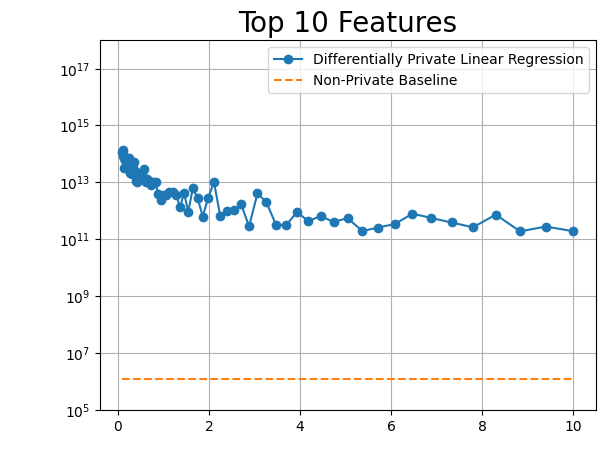

In [295]:
plt.plot(epsilons, priv_lr_errors, '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, base_lr_err * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("RMSE")
plt.title("Performance of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.ylim(10e4, 10e17)
plt.legend();

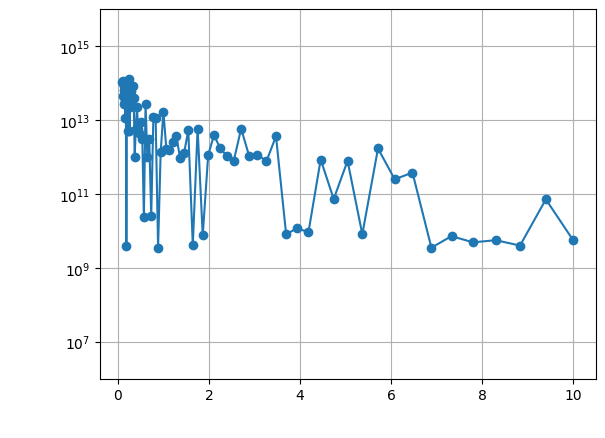

In [296]:
plt.plot(epsilons, lr_coef_distances, '-o')
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Distance From Baseline Model Coefficients")
plt.grid(axis="both")
plt.ylim(10e5, 10e15);
plt.title("Coefficients of DP vs Baseline Linear Regression");

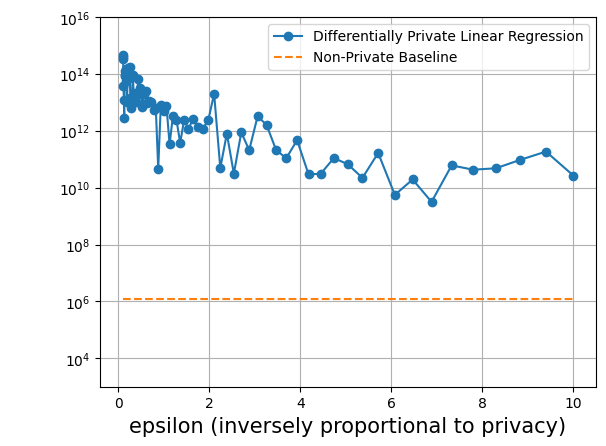

In [297]:
plt.plot(epsilons, np.abs(priv_lr_tax_surpluses), '-o', label="Differentially Private Linear Regression")
plt.plot(epsilons, np.abs(base_lr_tax_surplus) * np.ones_like(epsilons), '--', label="Non-Private Baseline")
plt.yscale("log")
plt.xlabel("epsilon (inversely proportional to privacy)")
plt.ylabel("Absolute Property Tax Difference")
plt.title("Property Tax Difference of DP vs Baseline Linear Regression")
plt.grid(axis="both")
plt.ylim(10e2, 10e15)
plt.legend();